# Spam/Non-Spam Email Classification

Welcome! In this project, I am predicting whether an email is spam or not spam using logistic regression and text features. My goal is to use natural language features to classify emails with high accuracy, and explore which words most influence spam detection. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/).

### 1. Data Loading and Setup

In [266]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
from datetime import datetime
from IPython.display import display, HTML

**Imported** the dataset below, and assigning making it usable by using pandas (e.g. pd.read_csv)

In [268]:
import zipfile

with zipfile.ZipFile("/Users/ethanngo/Desktop/spam_ham_data.zip") as item:
    with item.open("train.csv") as train_csv:
        original_training_data = pd.read_csv(train_csv)
    with item.open("test.csv") as test_csv:
        original_test_data = pd.read_csv(test_csv)

**Preprocessed the text** in the emails.

In [270]:
original_training_data['email'] = original_training_data['email'].str.lower()
original_test_data['email'] = original_test_data['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


**Filled missing (null) values**. Showcased below is the before and after.

In [272]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


Below, I **split the training data** (*original_training_data*) into separate datasets in order to train the models, and also **validate** them. I use *train_test_split* from the **scikit-learn library** to do this.

In [274]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 7)

### 2. Feature Engineering

**I extract features using word frequency to build my model.** 

The function *words_in_texts* below takes 2 parameters. 
- *words* is a list of words to find
- *texts* is a Series of strings to search in.

It returns a 2D array of 0s and 1s. 
- Row length: # of texts
- Column length: # of words

In [277]:
def words_in_texts(words, texts):
    
    indicator_array = np.array([texts.str.contains(word).astype(int) for word in words]).T
    return indicator_array

**Example Usage:**  

In [279]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### 3. Exploratory Data Analysis (EDA) 

I am exploring which words appear more in spam and non-spam emails to help explain how the model makes predictions. A sample of words I use is denoted by '*x*'.

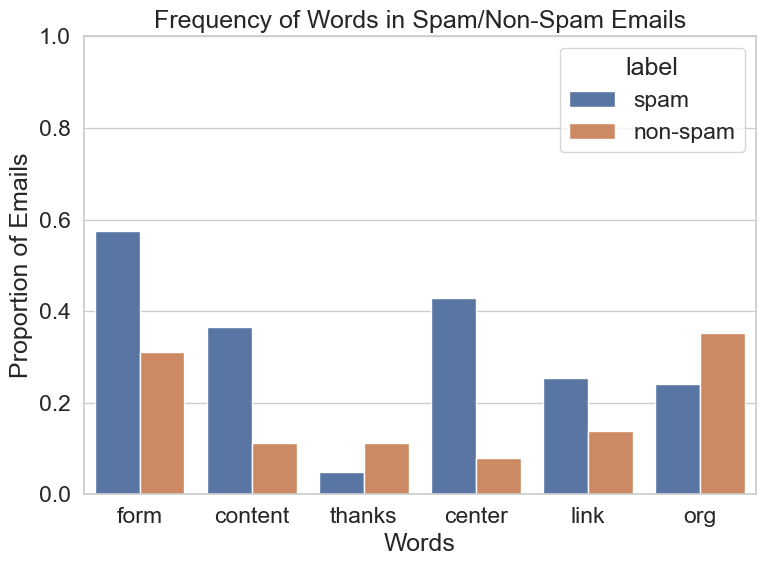

In [282]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))


# using all emails, so assumed to use len(train)
# for each word I chose, I need to go through the below process to get proportion
    # spam is 1, non-spam is 0, so I assume: where email is spam(1), what proportion of spam has the word "XXXX"

x = ['form', 'content', 'thanks', 'center', 'link', 'org']
y = words_in_texts(x, train["email"])

spam_train = train[train["spam"] == 1]
ham_train = train[train["spam"] == 0]

spam_email = words_in_texts(x, spam_train["email"])
ham_email = words_in_texts(x, ham_train["email"])

spam_proportions = spam_email.mean(axis = 0)
ham_proportions = ham_email.mean(axis = 0)

spamham = pd.DataFrame({
    "word": x,
    "spam": spam_email.mean(axis=0),
    "non-spam": ham_email.mean(axis=0)
})

spamham_melt = spamham.melt(id_vars="word", value_vars=["spam", "non-spam"], var_name="label", value_name="proportion")


sns.barplot(spamham_melt, x = "word", y = "proportion", hue = "label")
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")
plt.title("Frequency of Words in Spam/Non-Spam Emails")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

As you can see in the **barplot**, certain words such as 'form', 'content', and 'center' appear more in spam emails. Words like 'thanks' and 'org' appear more in non-spam emails.

When the feature is **binary**, it makes sense to compare its proportions across classes. 

### 4. Logistic Regression Classifier

The words in the list **some_words** below are useful for distinguishing between spam/non-spam emails. I use it to create NumPy arrays *X_train* and *Y_train*. 
- X_train is made using the earlier '*words_in_texts*' function
- Y_train is a vector of the correct labels for each email

In [286]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = train["spam"].values

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([0, 0, 0, 0, 0]))

I obtain the training accuracy using X_train, Y_train, and **LogisticRegression**, which is imported from **scikit-learn**. I use the penalty '**l2**', also known as **Ridge regression**, to mitigate overfitting.

In [288]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression(fit_intercept = True, penalty = 'l2')
my_model.fit(X_train, Y_train)

training_accuracy = np.mean(my_model.predict(X_train) == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7558897910288833


### 5. Evaluating Classifiers

I compute evaluation metrics for the model, such as **accuracy**, **precision**, and **recall**.

In [291]:
Y_train_hat = my_model.predict(X_train)

TP = sum((Y_train_hat == 1) & (Y_train == 1))
TN = sum((Y_train_hat == 0) & (Y_train == 0))
FP = sum((Y_train_hat == 1) & (Y_train == 0))
FN = sum((Y_train_hat == 0) & (Y_train == 1))

logistic_predictor_accuracy = (TP + TN) / len(X_train)
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (FP + TN)

print(logistic_predictor_accuracy)
print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

0.7558897910288833
TP=219, TN=5460, FP=128, FN=1706
logistic_predictor_precision=0.63, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


# ...

## Building My Own Model Now!

I am now interested in building my own model now. I start by conducting more **EDA** to determine which features are best to be used in my model. I find the **correlation between features**, and visualize it using a **heatmap**.

Text(0.5, 1.0, 'Correlation Heatmap: avg_word_length, has_html, num_words, spam')

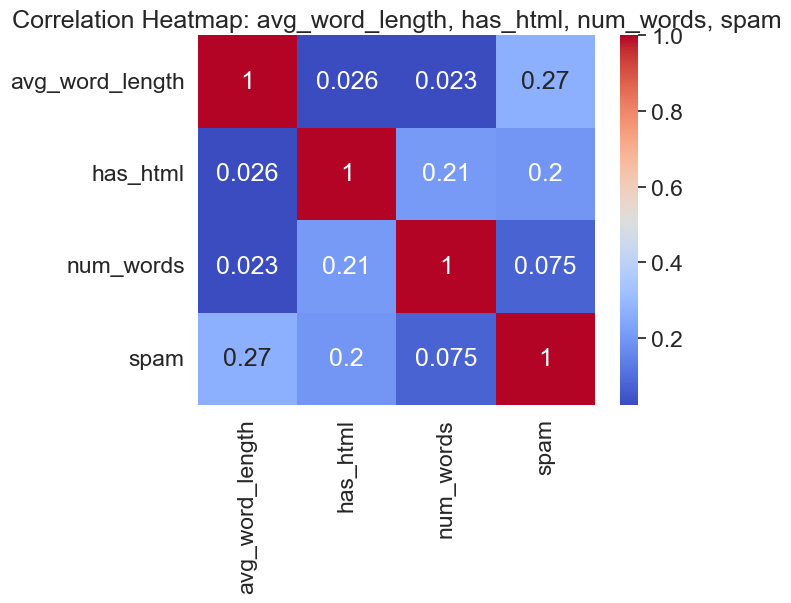

In [295]:
import re

train_2 = train.copy()

train_2['has_html'] = train_2['email'].apply(lambda x: bool(re.search(r'<.*?>', str(x)))).astype(int)
train_2['num_words'] = train_2['email'].apply(lambda x: len(str(x).split()))
train_2['avg_word_length'] = train_2['email'].apply(lambda x: sum(len(word) for word in str(x).split()) / (len(str(x).split()) + 1e-5))

numeric_features = ['avg_word_length', 'has_html', 'num_words', 'spam']
corr_matrix = train_2[numeric_features].corr()


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: avg_word_length, has_html, num_words, spam')

*A correlation of 1 (denoted by the diagonal) means a perfect correlation, and -1 means negative correlation. 0 means no correlation; independent.*

As you can see, a lot of features has **weak correlation** between them, which doesn't make these features the best to use in my model. However, I will end up using them anyway along with other features below! By using more features, **I improve the accuracy of my model while disregarding the concept of overfitting in this context.**

## My Model

In [298]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [299]:

#create copy
#get features
#

train_2 = train.copy()

train_2['has_html'] = train_2['email'].apply(lambda x: bool(re.search(r'<.*?>', str(x)))).astype(int)
train_2['has_special_char'] = train_2['email'].apply(lambda x: bool(re.search(r'[^a-zA-Z0-9\s!?]', str(x)))).astype(int)
train_2['num_exclamations'] = train_2['email'].apply(lambda x: str(x).count('!'))
train_2['num_words'] = train_2['email'].apply(lambda x: len(str(x).split()))
train_2['avg_word_length'] = train_2['email'].apply(lambda x: sum(len(word) for word in str(x).split()) / (len(str(x).split()) + 1e-5))
train_2['subject_length'] = train_2['subject'].apply(lambda x: len(str(x)))
train_2['has_subject'] = train_2['subject'].apply(lambda x: bool(str(x).strip())).astype(int)

keywords = ['body', 'business', 'html', 'money', 'offer', 'please', 'form', 'content', 'center']
for word in keywords:
    train_2[f'has_{word}'] = train_2['email'].apply(lambda x: word in str(x).lower()).astype(int)

features = ['has_html', 'has_special_char', 'num_exclamations', 'num_words',
            'avg_word_length', 'subject_length', 'has_subject'] + [f'has_{word}' for word in keywords]

X = train_2[features]
y = train_2['spam']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=2300)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)
val_accuracy = accuracy_score(y_val, y_val_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("Validation Accuracy", val_accuracy)
print("Training Accuracy:", train_accuracy)

Validation Accuracy 0.8948769128409847
Training Accuracy: 0.8926788685524126


**Below is my accuracy in the training dataset from on predictions based on my model.**

In [301]:
train_predictions = model.predict(X)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.8931185944363104

*The accuracy above is very similar to the accuracy of my model as well!*

## Model Evaluation

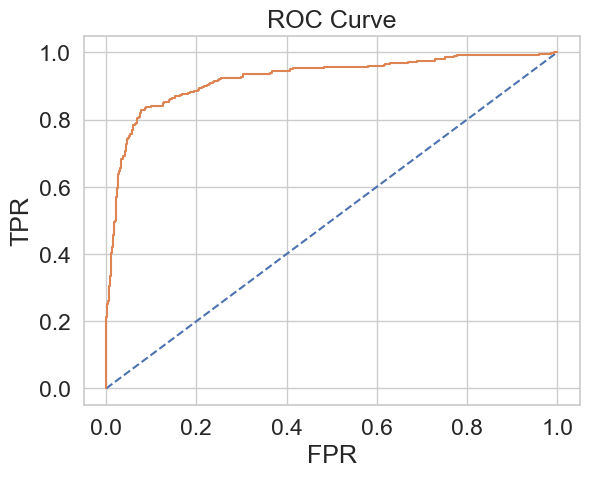

'Area Under Curve (AUC): 0.9234956010140035'

In [304]:
spammies = model.predict_proba(X_val)[:, 1]
fpr, tpr, cut_off = roc_curve(y_val, spammies)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()
AUC = f"Area Under Curve (AUC): {roc_auc}"
AUC

My model has an AUC of **0.92**, which is indicates that it is a **better-performing model**. 

- Note that a perfect model has an AUC of 1. 
- Note that the blue-dashed line cutting through the graph represents a random model, and has AUC of 0.5. 

# Conclusion

**In this project, I:**
- preprocessed email data and filled null values
- engineered features based on word frequency and relevance
- conducted EDA to understand how features contribute to spam classification
- used logistic regression to obtain my training dataset accuracy
- calculated evaluation metrics such as accuracy, precision, and recall
- created my own custom model classifier and found important words and features by trial-error
- evaluated my model using an ROC curve

**Notes:**

Choosing features for your model are important. If features appear in both spam and non-spam emails, the model will not perform well. In my case, I thoughtfully chose features and obtained an acccuracy just under 90%, which is strong.

The ROC curve having an AUC of 92% means that my model distinguishes between spam and non-spam emails pretty well, with rarely any mistakes.

Interpretability is another strength of the model. My model contains visiualizations where you can see which words influence predictions. This transparency is crucial in real-world applications. 

While this model performs well on the dataset used, it's important to note that my model may not be readily usable yet for widespread email classification. I am unsure if my model is overfitted to the dataset I obtained, and the only way to know is testing my model on other email datasets.

At the human level, we can obviously identify what is spam or not spam using cues or certain words in the email... it takes experience to notice this. However, to optimize this process, we can create models such as these, and deploy them! The most notable model everyone probably has is in their personal email platform, such as Gmail.

What I've gathered from this project is that the best way to improve my model's accuracy is to include more features. Certain features such as if the email contains HTML or whether it has the words 'money' or 'please' help the model in deciding what is spam or not.

# Summarized Conclusion

**In this project, I:**
- preprocessed email data and filled null values
- engineered features based on word frequency and relevance
- conducted EDA to understand how features contribute to spam classification
- used logistic regression to obtain my training dataset accuracy
- calculated evaluation metrics such as accuracy, precision, and recall
- created my own custom model classifier and found important words and features by trial-error
- evaluated my model using an ROC curve


The model performs well on this dataset, but testing on new data is needed to ensure generalizability.
With more features and refinement, it could become a practical spam filter.
This project shows how machine learning can automate and scale human intuition.